## Inclusión de información sobre el clima al dataset

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Descargado de OpenData de AEMET datos para el mes de septiembre de 2018:

In [2]:
PATH_AEMET_PER_DAY = '../../data/raw/other-data/aemet_per_day.json'
PATH_BIKES = '../../data/clean/bike_data_clean.csv'

In [3]:
df_weather = pd.read_json(PATH_AEMET_PER_DAY, orient='records')
df_bikes = pd.read_csv(PATH_BIKES)

In [4]:
df_weather.head()

,date,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin
0,2018-09-01,3195,"MADRID, RETIRO",MADRID,667,"27,3","0,0","21,0",06:50,"33,6",13:40,4,"1,1","7,5",01:50,"943,4",10,"939,2",19
1,2018-09-02,3195,"MADRID, RETIRO",MADRID,667,"27,5","1,2","20,2",22:10,"34,8",14:30,34,"1,7","9,2",22:40,"942,4",08,"937,0",18
2,2018-09-03,3195,"MADRID, RETIRO",MADRID,667,"26,8","0,0","22,3",06:10,"31,3",14:50,11,"1,7","7,8",03:40,"937,5",10,"933,7",16
3,2018-09-04,3195,"MADRID, RETIRO",MADRID,667,"24,4","0,0","19,4",06:20,"29,5",13:30,18,"1,4","6,9",15:20,"938,5",08,"934,6",17
4,2018-09-05,3195,"MADRID, RETIRO",MADRID,667,"23,0","0,0","18,3",05:10,"27,8",13:40,25,"2,8","10,0",19:30,"939,6",09,"936,6",18


Sólo vamos a emplear el viento, las precipitaciones y la temperatura. Aemet sólo nos proporciona la información diaria, no horaria. Para la predicción de la demanda horaria, necesitamos estimar los valores de estas magnitudes por hora:
- Para el viento, asumimos esa velocidad media para todo el día. 
- Para las precipitaciones:
    - Decidir si distribuir esas precipitaciones a lo largo del día (mmm no) o dejar esas precipitaciones para todo el día -> analizar si hay un comportamiento extraño
- Para la temperatura:
    - Asumir que la temperatura varía a lo largo del día n de manera lineal en los siguientes tramos:
        - [horatmin(n), tmin(n)] -> [horatmax(n), tmax(n)]
        - [horatmax(n), tmax(n)] -> [horatmax(n+1), tmax(n+1)]

# Análisis diario

In [15]:
# merging data
df_weather['weather_date'] = pd.to_datetime(df_weather['date'])
df_bikes['ride_date'] = pd.to_datetime(pd.to_datetime(df_bikes['unplug_hourTime']).dt.date)
df_rides_per_day = df_bikes.groupby('ride_date').size().reset_index(name='rides')
df_rides_per_day = df_rides_per_day.merge(df_weather, how='left', left_on='ride_date', right_on='weather_date').drop(columns='weather_date')
df_rides_per_day = df_rides_per_day.drop(['date', 'indicativo', 'nombre', 'provincia', 'altitud'], axis=1) # dropping unnecessary columns

In [16]:
df_rides_per_day.head()

,ride_date,rides,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin
0,2018-09-01,8232,"27,3","0,0","21,0",06:50,"33,6",13:40,4,"1,1","7,5",01:50,"943,4",10,"939,2",19
1,2018-09-02,8164,"27,5","1,2","20,2",22:10,"34,8",14:30,34,"1,7","9,2",22:40,"942,4",08,"937,0",18
2,2018-09-03,12472,"26,8","0,0","22,3",06:10,"31,3",14:50,11,"1,7","7,8",03:40,"937,5",10,"933,7",16
3,2018-09-04,13738,"24,4","0,0","19,4",06:20,"29,5",13:30,18,"1,4","6,9",15:20,"938,5",08,"934,6",17
4,2018-09-05,13959,"23,0","0,0","18,3",05:10,"27,8",13:40,25,"2,8","10,0",19:30,"939,6",09,"936,6",18


In [17]:
df_rides_per_day.dtypes

ride_date      datetime64[ns]
rides                   int64
tmed                   object
prec                   object
tmin                   object
horatmin               object
tmax                   object
horatmax               object
dir                     int64
velmedia               object
racha                  object
horaracha              object
presMax                object
horaPresMax            object
presMin                object
horaPresMin            object
dtype: object

In [18]:
# data types transformation
df_rides_per_day['tmed'] =  pd.to_numeric(df_rides_per_day['tmed'].str.replace(',', '.'), downcast='float')
df_rides_per_day['prec'] =  pd.to_numeric(df_rides_per_day['prec'].str.replace(',', '.'), downcast='float')
df_rides_per_day['tmin'] =  pd.to_numeric(df_rides_per_day['tmin'].str.replace(',', '.'), downcast='float')
df_rides_per_day['tmax'] =  pd.to_numeric(df_rides_per_day['tmax'].str.replace(',', '.'), downcast='float')
df_rides_per_day['velmedia'] =  pd.to_numeric(df_rides_per_day['velmedia'].str.replace(',', '.'), downcast='float')
df_rides_per_day['racha'] =  pd.to_numeric(df_rides_per_day['racha'].str.replace(',', '.'), downcast='float')
df_rides_per_day['presMax'] =  pd.to_numeric(df_rides_per_day['presMax'].str.replace(',', '.'), downcast='float')
df_rides_per_day['presMin'] =  pd.to_numeric(df_rides_per_day['presMin'].str.replace(',', '.'), downcast='float')

Representación de las precipitaciones, temperatura, viento, presión y cantidad de trayectos diarios:

In [19]:
df_rides_per_day = df_rides_per_day.set_index('ride_date')

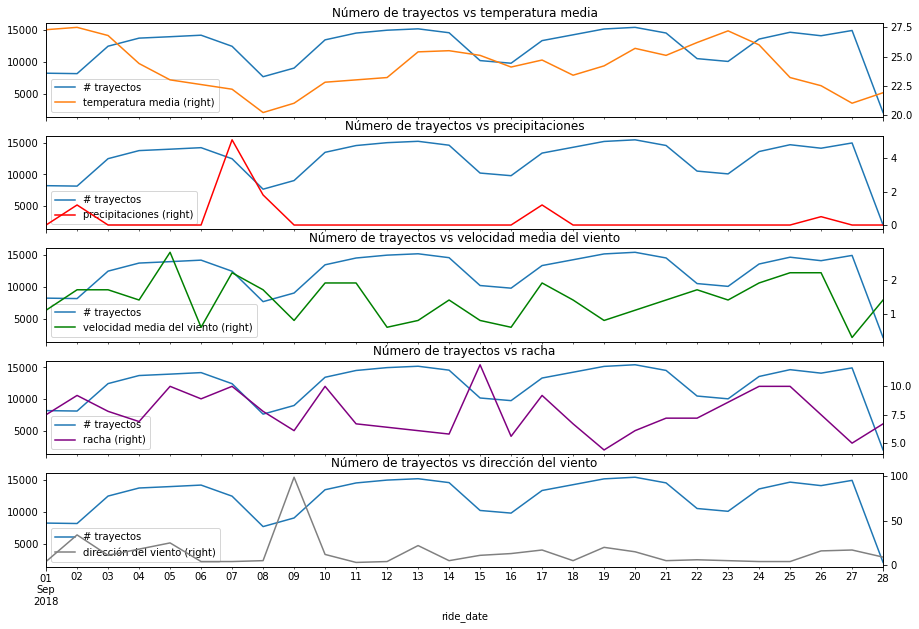

In [20]:
fig, axis = plt.subplots(5, 1, figsize=(15, 10))
df_rides_per_day['rides'].plot(ax=axis[0], label='# trayectos', legend=True)
df_rides_per_day['tmed'].plot(ax=axis[0], secondary_y=True, label = 'temperatura media', legend=True)
axis[0].title.set_text('Número de trayectos vs temperatura media')
df_rides_per_day['rides'].plot(ax=axis[1], label='# trayectos', legend=True)
df_rides_per_day['prec'].plot(ax=axis[1], secondary_y=True, label = 'precipitaciones', legend=True, color='red')
axis[1].title.set_text('Número de trayectos vs precipitaciones')
df_rides_per_day['rides'].plot(ax=axis[2], label='# trayectos', legend=True)
df_rides_per_day['velmedia'].plot(ax=axis[2], secondary_y=True, label = 'velocidad media del viento', legend=True, color='green')
axis[2].title.set_text('Número de trayectos vs velocidad media del viento')
df_rides_per_day['rides'].plot(ax=axis[3], label='# trayectos', legend=True)
df_rides_per_day['racha'].plot(ax=axis[3], secondary_y=True, label = 'racha', legend=True, color='purple')
axis[3].title.set_text('Número de trayectos vs racha')
df_rides_per_day['rides'].plot(ax=axis[4], label='# trayectos', legend=True)
df_rides_per_day['dir'].plot(ax=axis[4], secondary_y=True, label = 'dirección del viento', legend=True, color='gray')
axis[4].title.set_text('Número de trayectos vs dirección del viento')

Observando las gráficas, podemos intuir una relación entre el número de trayectos realizados al día y la cantidad de precipitaciones. Vemos un pico de lluvia el día 7, coincidiendo con una disminución en el número de trayectos. Hacia el día 17 también hay un pico (menos elevado) de lluvia para el que no se aprecia una disminución de trayectos: puede ser porque (a) la lluvia fuera a una hora poco concurrida para bicimad, como por la noche [no tenemos las precipitaciones por hora] o porque fuera muy poca lluvia y no tuviera impacto con respecto al uso del servicio. Sin embargo, esta disminución en los trayectos se podría explicar por la racha de viento presente es mismo día. 

Correlación entre variables de clima y cantidad de trayectos en bici:

In [21]:
df_rides_per_day.corr()

,rides,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin
rides,1.000000,0.019957,-0.120611,0.040880,0.003531,-0.172736,0.019125,-0.107120,0.022149,0.124566
tmed,0.019957,1.000000,-0.228444,0.896244,0.957359,-0.214194,0.017647,0.123015,-0.202073,-0.246053
prec,-0.120611,-0.228444,1.000000,-0.283052,-0.163460,-0.078518,0.341499,0.302867,-0.252283,-0.229920
tmin,0.040880,0.896244,-0.283052,1.000000,0.730257,-0.242970,0.112319,0.194495,-0.263519,-0.303070
tmax,0.003531,0.957359,-0.163460,0.730257,1.000000,-0.167692,-0.038445,0.065666,-0.143802,-0.185819
dir,-0.172736,-0.214194,-0.078518,-0.242970,-0.167692,1.000000,-0.167326,-0.177983,-0.035613,-0.072915
velmedia,0.019125,0.017647,0.341499,0.112319,-0.038445,-0.167326,1.000000,0.542083,-0.123909,-0.162931
racha,-0.107120,0.123015,0.302867,0.194495,0.065666,-0.177983,0.542083,1.000000,-0.204826,-0.211374
presMax,0.022149,-0.202073,-0.252283,-0.263519,-0.143802,-0.035613,-0.123909,-0.204826,1.000000,0.953705
presMin,0.124566,-0.246053,-0.229920,-0.303070,-0.185819,-0.072915,-0.162931,-0.211374,0.953705,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff4efee41f0>,)

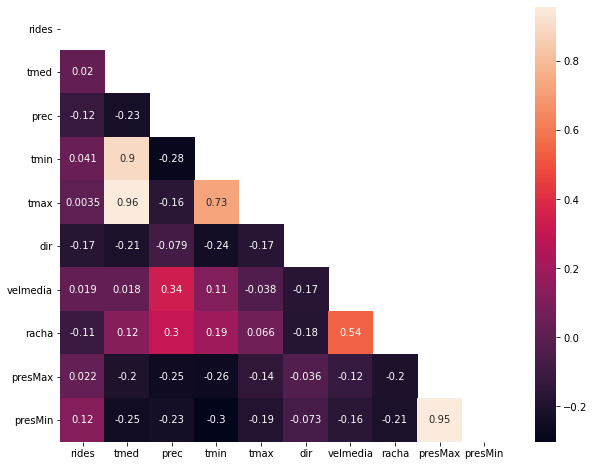

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df_rides_per_day.corr(), mask=np.triu(np.ones(df_rides_per_day.corr().shape)).astype(np.bool), annot=True),# cmap='YlGnBu')

Tenemos tan poca cantidad de datos (28 muestras) que el análisis de correlación no es fiable y no se pueden extraer conclusiones. Además, septiembre tiene un clima muy estable, lo que provoca que todas las muestras tengan datos de clima similar. Pese a que existen algunas muestras con un clima diferente (sobre las precipitaciones, en particular), tampoco conocemos las horas a las que se produjeron dichas precipitaciones, por lo que no podemos conocer de manera fiable la relación entre las precipitaciones y la cantidad de trayectos. 